In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

DATA_PATH = Path("attendance_with_features.csv")
raw_df = pd.read_csv(DATA_PATH)


In [2]:
from typing import Optional

def time_to_minutes(t: Optional[str]) -> float:
    if not isinstance(t, str) or not t:
        return np.nan
    h, m, s = map(int, t.split(":"))
    return h * 60 + m + s / 60.0


df = raw_df.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
first_month = df["date"].dt.to_period("M").min()
df = df[df["date"].dt.to_period("M") != first_month].copy()

school_start_minutes = 7 * 60  # assume jam masuk 07:00

df["arrival_minutes"] = df["checkin_time"].apply(time_to_minutes)
df["departure_minutes"] = df["checkout_time"].apply(time_to_minutes)

minutes_late = df["arrival_minutes"] - school_start_minutes
minutes_late = minutes_late.mask(minutes_late < 0, 0)
minutes_late = minutes_late.mask(df["note"].isin(["alpa", "libur"]))
df["minutes_late"] = minutes_late

df["is_weekend"] = df["DayOfWeek"].isin(["Saturday", "Sunday"]).astype(int)

valid_statuses = ["hadir", "telat", "alpa"]
df_model = df[df["note"].isin(valid_statuses)].copy()

numeric_cols = [
    "arrival_minutes",
    "departure_minutes",
    "minutes_late",
    "Count_Telat_7D",
    "Count_Alpa_30D",
    "Streak_Telat",
    "Avg_Arrival_Time_7D",
    "is_weekend",
]

df_model[numeric_cols] = df_model[numeric_cols].apply(pd.to_numeric, errors="coerce")


## EDA ringkas
Beberapa ringkasan cepat untuk memahami distribusi status, missing value, dan pola kedatangan.

In [3]:
# EDA ringkas
overview = {
    "rows": len(df_model),
    "cols": df_model.shape[1],
    "unique_siswa": df_model["rfid_tag"].nunique(),
    "first_month_excluded": str(first_month),
}

status_raw = df_model["note"].value_counts(dropna=False)

eda_cols = [
    "checkin_time",
    "checkout_time",
    "Lag_1_Status",
    "Count_Telat_7D",
    "Count_Alpa_30D",
    "Streak_Telat",
    "Avg_Arrival_Time_7D",
]
missing_pct = (df_model[eda_cols].isna().mean() * 100).round(2).sort_values(ascending=False)

arrival_stats = (
    df_model[["arrival_minutes", "minutes_late"]]
    .describe(percentiles=[0.25, 0.5, 0.75])
    .round(2)
)

overview, status_raw, missing_pct, arrival_stats

({'rows': 85153,
  'cols': 16,
  'unique_siswa': 1491,
  'first_month_excluded': '2025-08'},
 note
 hadir    49054
 alpa     28919
 telat     7180
 Name: count, dtype: int64,
 checkout_time          56.84
 checkin_time           33.96
 Avg_Arrival_Time_7D    11.16
 Lag_1_Status            0.14
 Count_Telat_7D          0.00
 Count_Alpa_30D          0.00
 Streak_Telat            0.00
 dtype: float64,
        arrival_minutes  minutes_late
 count         56234.00      56234.00
 mean            361.06         14.25
 std              81.49         63.56
 min             273.98          0.00
 25%             333.90          0.00
 50%             344.27          0.00
 75%             354.17          0.00
 max             983.52        563.52)

## Preprocessing & fitur untuk SVM
- Numeric: arrival/departure/minutes_late dan hitungan keterlambatan/ketidakhadiran.
- Categorical: DayOfWeek dan Lag_1_Status (akan di-OneHot).
- Imputasi: median untuk numeric, modus untuk categorical.
- Standarisasi: StandardScaler untuk numeric sebelum SVM RBF.

- yang bisa diubah dari sini sampe bawah

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

# Feature/target split. fitur dari dataset kamu yang di pake buat training SVM
X = df_model.copy()
y = X.pop("note")

numeric_cols = [
    "arrival_minutes",
    "departure_minutes",
    "minutes_late",
    "Count_Telat_7D",
    "Count_Alpa_30D",
    "Streak_Telat",
    "Avg_Arrival_Time_7D",
    "is_weekend",
]

categorical_cols = ["DayOfWeek", "Lag_1_Status"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            SVC(kernel="rbf", C=3, gamma="scale", class_weight="balanced", probability=True),
        ),
    ]
)

clf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['arrival_minutes',
                                                   'departure_minutes',
                                                   'minutes_late',
                                                   'Count_Telat_7D',
                                                   'Count_Alpa_30D',
                                                   'Streak_Telat',
                                                   'Avg_Arrival_Time_7D',
                                                   'is_weekend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['DayOfWeek',
                                                   'Lag_1_Status'])])),
                ('model', SVC(C=3, class_weight='balanced', probability=True))])

In [4]:
# svm tanpa PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# definisikan model
# definisikan SVM
clf = SVC(kernel='rbf', C=1.0, gamma='scale')

# training
clf.fit(X_train, y_train)

# prediksi
y_pred = clf.predict(X_test)

# evaluasi
report = classification_report(y_test, y_pred, digits=3, output_dict=True)
conf_mat = confusion_matrix(y_test, y_pred)

report, conf_mat


NameError: name 'X_train' is not defined

## SVM dengan PCA
Varian pipeline yang mereduksi fitur (numeric + one-hot) memakai PCA sebelum SVM.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

# SVM dengan PCA (ubah n_components nilainya bisa kamu coba dari 0-1, contoh 0.93/1 dan parameter c=3 ubah seperlunya)
# promt: berikan saya rekomendasi hypertune untuk model SVM tanpa PCA dan dengan PCA, bagian mana saja yang bisa saya ubah parameternya
pca_numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

pca_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

pca_preprocessor = ColumnTransformer(
    transformers=[
        ("num", pca_numeric_transformer, numeric_cols),
        ("cat", pca_categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

pca_clf = Pipeline(
    steps=[
        ("preprocess", pca_preprocessor),
        ("pca", PCA(n_components=0.95, random_state=42)),
        (
            "model",
            SVC(kernel="rbf", C=3, gamma="scale", class_weight="balanced", probability=True),
        ),
    ]
)

pca_clf.fit(X_train, y_train)

pca_pred = pca_clf.predict(X_test)
pca_report = classification_report(y_test, pca_pred, digits=3, output_dict=True)
pca_conf_mat = confusion_matrix(y_test, pca_pred)

pca_clf.named_steps["pca"].n_components_, pca_report, pca_conf_mat

(np.int64(9),
 {'alpa': {'precision': 0.7225300716313016,
   'recall': 0.9242738589211619,
   'f1-score': 0.811044527042403,
   'support': 5784.0},
  'hadir': {'precision': 0.9429226653076825,
   'recall': 0.7543573539904189,
   'f1-score': 0.8381653454133635,
   'support': 9811.0},
  'telat': {'precision': 0.7964105440269209,
   'recall': 0.9888579387186629,
   'f1-score': 0.8822615719167444,
   'support': 1436.0},
  'accuracy': 0.8318360636486407,
  'macro avg': {'precision': 0.8206210936553017,
   'recall': 0.8891630505434146,
   'f1-score': 0.843823814790837,
   'support': 17031.0},
  'weighted avg': {'precision': 0.8557203772457155,
   'recall': 0.8318360636486407,
   'f1-score': 0.8326727359248556,
   'support': 17031.0}},
 array([[5346,  434,    4],
        [2051, 7401,  359],
        [   2,   14, 1420]]))

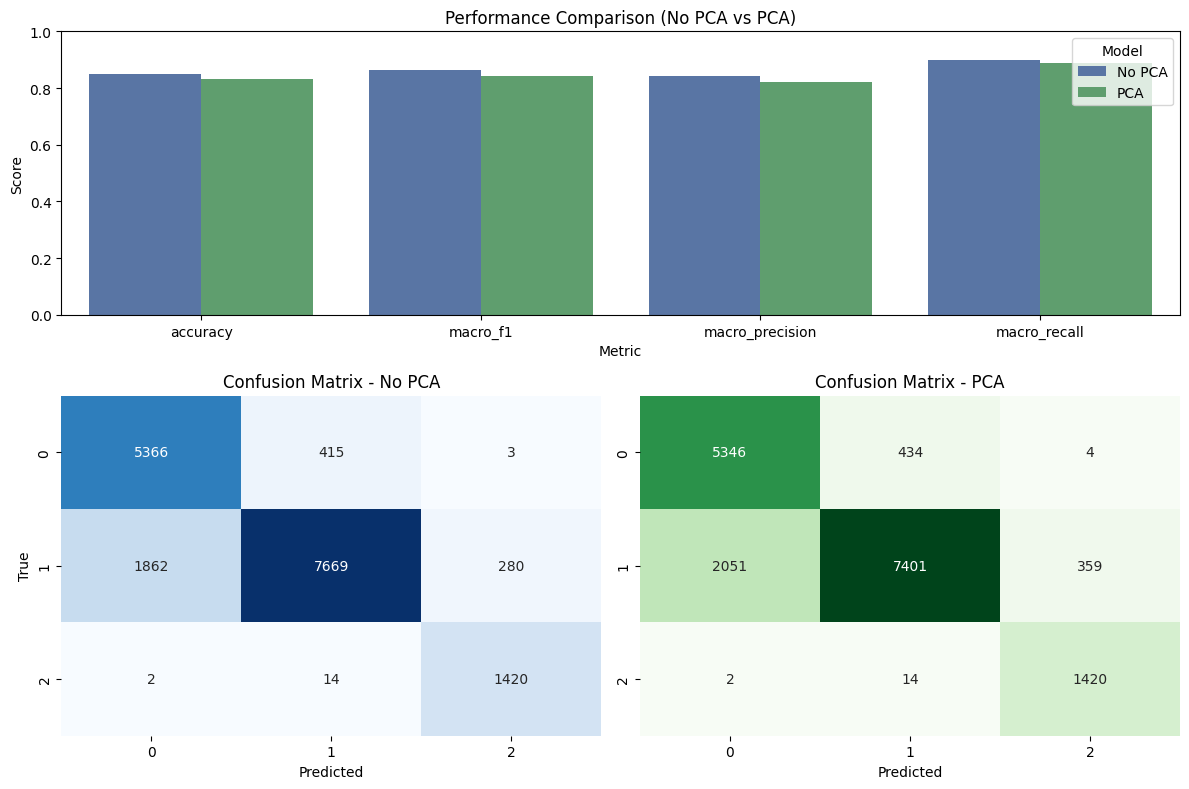

In [ ]:
# Visualization: compare without vs with PCA
import matplotlib.pyplot as plt
import seaborn as sns

metrics_df = pd.DataFrame(
    [
        {"model": "No PCA", "metric": "accuracy", "value": report["accuracy"]},
        {"model": "No PCA", "metric": "macro_f1", "value": report["macro avg"]["f1-score"]},
        {"model": "No PCA", "metric": "macro_precision", "value": report["macro avg"]["precision"]},
        {"model": "No PCA", "metric": "macro_recall", "value": report["macro avg"]["recall"]},
        {"model": "PCA", "metric": "accuracy", "value": pca_report["accuracy"]},
        {"model": "PCA", "metric": "macro_f1", "value": pca_report["macro avg"]["f1-score"]},
        {"model": "PCA", "metric": "macro_precision", "value": pca_report["macro avg"]["precision"]},
        {"model": "PCA", "metric": "macro_recall", "value": pca_report["macro avg"]["recall"]},
    ]
)

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

ax0 = fig.add_subplot(gs[0, :])
sns.barplot(data=metrics_df, x="metric", y="value", hue="model", palette=["#4C72B0", "#55A868"], ax=ax0)
ax0.set_ylim(0, 1)
ax0.set_title("Performance Comparison (No PCA vs PCA)")
ax0.set_xlabel("Metric")
ax0.set_ylabel("Score")
ax0.legend(title="Model")

ax1 = fig.add_subplot(gs[1, 0])
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax1)
ax1.set_title("Confusion Matrix - No PCA")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

ax2 = fig.add_subplot(gs[1, 1])
sns.heatmap(pca_conf_mat, annot=True, fmt="d", cmap="Greens", cbar=False, ax=ax2)
ax2.set_title("Confusion Matrix - PCA")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()